In [ ]:
!pip install dotted-dict

In [ ]:
from pathlib import Path
import pprint
import hashlib

import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as T
import torch.nn.functional as F
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
import numpy as np
from dotted_dict import DottedDict

In [ ]:
config = DottedDict({
    'mnist_train': {},
    'mnist_valid': {},
    'affnist_train': {},
    'affnist_valid': {}
})
config.p_data_root_mnist = "./../data"
config.p_data_affnist = "./../data/AFFNIST"

config.img_height = 40
config.img_width = 40

# MNIST TRAIN CONFIG
config.mnist_train.samples_per_sample = 1
config.mnist_train.strip_zeros = False
config.mnist_train.file_name = "mnist_train.pt"

# MNIST VALID CONFIG
config.mnist_valid.samples_per_sample = 1
config.mnist_valid.strip_zeros = False
config.mnist_valid.file_name = "mnist_valid.pt"

# AFFNIST TRAIN CONFIG
config.rotate_degrees = (-20, 20)
config.sheer_degrees = (-40, 40)
config.scale = (0.8, 1.2)

config.affnist_train.samples_per_sample = 1
config.affnist_train.file_name = "affnist_train.pt"

# AFFNIST VALID CONFIG
config.affnist_valid.samples_per_sample = 1
config.affnist_valid.file_name = "affnist_valid.pt"

In [ ]:
pp = pprint.PrettyPrinter(indent=4)
pprint = pp.pprint 
pprint(config)

In [ ]:
# create dataset directory
Path(config.p_data_affnist).mkdir(exist_ok=True, parents=True)

In [ ]:
def get_content_idcs_1d(T):
    assert len(T.shape) == 1
    for idx_from in range(len(T)):
        if T[idx_from] > 0:
            break
    for idx_to in range(len(T) -1, 0, -1):
        if T[idx_to] > 0:
            idx_to += 1
            break
    return idx_from, idx_to

def strip_tensor_2d(T):
    assert len(T.shape) == 2
    col_from, col_to = get_content_idcs_1d(T.sum(axis=0))
    row_from, row_to = get_content_idcs_1d(T.sum(axis=1))
    return T[row_from:row_to, col_from:col_to]

def randomly_place(A, B=None, h_B=None, w_B=None):
    """
        Randly place A into B
        with a margin of 1
    """
    assert len(A.shape) == 2
    if B is not None:
        assert len(B.shape) == 2
        h_b, w_B = B.shape
    else:
        assert h_B is not None
        assert w_B is not None
        B = torch.zeros((h_B, w_B), dtype=A.dtype)
        
    h_A, w_A = A.shape
    #
    row_from = np.random.randint(low=0, high=h_B - h_A + 1)
    row_to = row_from + h_A

    col_from = np.random.randint(low=0, high=w_B - w_A + 1)
    col_to = col_from + w_A
    B[row_from:row_to, col_from:col_to] = A
    return B

def create_padded_mnist_tensors(train, strip, height, width, n_samples, p_root):
    ds = datasets.MNIST(root=p_root, train=train, download=True, transform=None)
    data, targets = ds.data, ds.targets

    all_imgs = []
    all_targets = []
    for idx, img in enumerate(data):
        if strip:
            img = strip_tensor_2d(img)
        all_imgs += torch.stack([randomly_place(img, h_B=height, w_B=width) for _ in range(n_samples)])
    all_imgs = torch.stack(all_imgs)
    all_targets = targets.repeat_interleave(n_samples)
    return all_imgs, all_targets

def create_affnist_tensors(train, height, width, n_samples, p_root, transforms):
    ds = datasets.MNIST(root=p_root, train=train, download=True, transform=None)
    data, targets = ds.data, ds.targets
    
    # padding
    pad = (height - 28) // 2
    assert 2*pad + 28 == height
    assert height == width
    
    all_imgs = []
    all_targets = []
    for idx, img in enumerate(data):
        for _ in range(n_samples):
            # pad img to 40x40
            img_aff = F.pad(input=img, pad=(pad, pad, pad, pad), mode='constant', value=0)

            # rotation, scaling, sheering
            img_aff = transforms(img_aff.unsqueeze(0)).squeeze()
            r=n
            # strip img
            img_aff = strip_tensor_2d(img_aff)
    
            # translate
            img_aff = randomly_place(img_aff, h_B=height, w_B=width)
            
            all_imgs.append(img_aff)
    all_imgs = torch.stack(all_imgs)
    all_targets = targets.repeat_interleave(n_samples)
    return all_imgs, all_targets

# MNIST Train Data

In [ ]:
imgs, targets = create_padded_mnist_tensors(
    train=True,
    strip=config.mnist_train.strip_zeros,
    height=config.img_height,
    width=config.img_width,
    n_samples=config.mnist_train.samples_per_sample,
    p_root=config.p_data_root_mnist
)
print(imgs.shape, targets.shape)

In [ ]:
n_vis = 8
grid = torchvision.utils.make_grid(imgs[:n_vis].unsqueeze(1), nrow=config.mnist_train.samples_per_sample)
plt.figure(figsize=(2 * 2, n_vis * 2))
plt.imshow(grid.permute(1,2,0))

In [ ]:
targets[:n_vis]

In [ ]:
p_mnist_train = Path(config.p_data_affnist) / config.mnist_train.file_name

# save stuff
torch.save([imgs, targets], p_mnist_train)

# try load
imgs, targets = torch.load(p_mnist_train)
print(imgs.shape, targets.shape)

In [ ]:
hashlib.md5(open(p_mnist_train,'rb').read()).hexdigest()

# MNIST Valid Data

In [ ]:
imgs, targets = create_padded_mnist_tensors(
    train=False,
    strip=config.mnist_valid.strip_zeros,
    height=config.img_height,
    width=config.img_width,
    n_samples=config.mnist_valid.samples_per_sample,
    p_root=config.p_data_root_mnist
)
print(imgs.shape, targets.shape)

In [ ]:
n_vis = 8
grid = torchvision.utils.make_grid(imgs[:n_vis].unsqueeze(1), nrow=config.mnist_train.samples_per_sample)
plt.figure(figsize=(2 * 2, n_vis * 2))
plt.imshow(grid.permute(1,2,0))

In [ ]:
targets[:n_vis]

In [ ]:
p_mnist_valid = Path(config.p_data_affnist) / config.mnist_valid.file_name

# save stuff
torch.save([imgs, targets], p_mnist_valid)

# try load
imgs, targets = torch.load(p_mnist_valid)
print(imgs.shape, targets.shape)

In [ ]:
hashlib.md5(open(p_mnist_valid,'rb').read()).hexdigest()

# AffNIST Train Data 

The AffNIST dataset is created by padding the orignal 28x28 MNIST images with 6 px to 40x40 and then randomly affine transform them via:
- rotation within 20 degrees
- sheering withing 45 degrees
- scaling from 0.8 to 1.2 in both vertical and horizonal directions
- translations within 8 pixel

In [ ]:
pprint(config)

In [ ]:
transforms = T.RandomAffine(
    degrees=config.rotate_degrees,
    translate=None,  # we do that later manually
    shear=config.sheer_degrees,
    scale=config.scale
)

In [ ]:
imgs, targets = create_affnist_tensors(
    train=True,
    height=config.img_height,
    width=config.img_width,
    n_samples=config.affnist_train.samples_per_sample,
    p_root=config.p_data_root_mnist,
    transforms=transforms
)
print(imgs.shape, targets.shape)

In [ ]:
n_vis = 16
grid = torchvision.utils.make_grid(imgs[:n_vis].unsqueeze(1), nrow=config.mnist_train.samples_per_sample)
plt.figure(figsize=(2 * 2, n_vis * 2))
plt.imshow(grid.permute(1,2,0))

In [ ]:
targets[:n_vis]

In [ ]:
p_affnist_train = Path(config.p_data_affnist) / config.affnist_train.file_name

# save stuff
torch.save([imgs, targets], p_affnist_train)

# try load
imgs, targets = torch.load(p_affnist_train)
print(imgs.shape, targets.shape)

In [ ]:
hashlib.md5(open(p_affnist_train,'rb').read()).hexdigest()

# AffNIST Valid Data 

In [ ]:
transforms = T.RandomAffine(
    degrees=config.rotate_degrees,
    translate=None,  # we do that later manually
    shear=config.sheer_degrees,
    scale=config.scale
)

In [ ]:
imgs, targets = create_affnist_tensors(
    train=False,
    height=config.img_height,
    width=config.img_width,
    n_samples=config.affnist_valid.samples_per_sample,
    p_root=config.p_data_root_mnist,
    transforms=transforms
)
print(imgs.shape, targets.shape)

In [ ]:
n_vis = 16
grid = torchvision.utils.make_grid(imgs[:n_vis].unsqueeze(1), nrow=config.mnist_train.samples_per_sample)
plt.figure(figsize=(2 * 2, n_vis * 2))
plt.imshow(grid.permute(1,2,0))

In [ ]:
print(targets[:n_vis])

In [ ]:
p_affnist_valid = Path(config.p_data_affnist) / config.affnist_valid.file_name

# save stuff
torch.save([imgs, targets], p_affnist_valid)

# try load
imgs, targets = torch.load(p_affnist_valid)
print(imgs.shape, targets.shape)

In [ ]:
hashlib.md5(open(p_affnist_valid,'rb').read()).hexdigest()

## AffNIST Dataset class

In [1]:
import sys
sys.path.append("./..")
from datasets import AffNIST
import torch
import torchvision.transforms as T
import matplotlib.pyplot as plt


In [ ]:
split = "affnist_valid"
transform = None
target_transform = None
p_root = './../data'

ds = AffNIST(p_root, split, transform, target_transform)

In [ ]:
plt.imshow(ds[0][0].squeeze())
plt.title(ds[0][1])

In [ ]:
ds.data.shape

In [ ]:
transform = None
target_transform = None
p_root = './../data'

for split in AffNIST.SPLIT_FILES.values():
    ds = AffNIST(p_root, split[:-3], transform, target_transform)
    print("Split: {} length: {}".format(split, len(ds)))
    plt.imshow(ds[989][0].squeeze())
    plt.title(ds[989][1])
    plt.show()

In [ ]:
transform_train = T.Compose([T.ToTensor()])

In [3]:
split = "affnist_valid"
transform = None
target_transform = None
p_root = './../data'

ds = AffNIST(p_root, split, None, target_transform)

In [4]:
ds[0][0].shape
ds[0][0].min()
ds[0][0].max()

tensor(1.)

In [7]:
ds.data.shape
ds.data.dtype

torch.uint8

In [8]:
img = ds.data[0]

torch.float32
torch.Size([1, 40, 40])


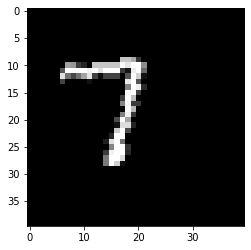

In [13]:
img = ds[0][0]
print(img.dtype)
print(img.shape)
plt.imshow(img.squeeze(), cmap="gray")